# Data Science Challenge

In [225]:
# If additional packages are needed that are not installed by default, uncomment the last two lines of this 
# cell and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

import sys
import pandas as pd
import numpy as np
import os
import seaborn as sns
import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import shap
from datetime import date
import chart_studio.plotly as py
import plotly.graph_objects as go

from utils import *
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#!{sys.executable} -m pip install <package list>

In [3]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)

## Data Description

Column | Description
:---|:---
`id` | Record index
`timestamp` | Datetime (YYYY:MM:DD HH AM/PM)
`season` | Season (spring, summer, fall, winter)
`holiday` | Whether day is a holiday or not (Yes or No)
`workingday` | Whether day is a working day or not (Yes or No)
`weather`| Weather condition (Clear or partly cloudy, Mist, Light snow or rain, heavy rain/ice pellets/ snow + fog 
`temp`| Average temperature recorded for the hour ( in degree Celsius)
`temp_feel`| Average feeling temperature recorded for the hour ( in degree Celsius)
`hum`| Average humidity recorded for the hour (in %)
`windspeed`| Average wind speed recorded for the hour (in miles/hour)
`demand`| Hourly count of bikes rented

## Data Wrangling & Visualization

The dataset is already loaded below

parsed timestamp columns with dtype timestamp

set id as index

Decomposed timestamp column into year, month, time of week etc

In [221]:

df_train = (pd.read_csv('train.csv', parse_dates=['timestamp'])
              .pipe(add_datepart, 'timestamp', drop=False, ret=True)
              .set_index('id'))

In [222]:
df_test = (pd.read_csv('test.csv', parse_dates=['timestamp'])
            .pipe(add_datepart, 'timestamp', drop=False, ret=True)
            .set_index('id'))

## Data Sample

In [155]:
df_train.head()

,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampElapsed
id,,,,,,,,,,,,,,,,,,,,,,,
1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589,2017,1,52,1,6,1,False,True,False,True,False,True,1483228800
2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879,2017,1,52,1,6,1,False,True,False,True,False,True,1483232400
3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736,2017,1,52,1,6,1,False,True,False,True,False,True,1483236000
4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949,2017,1,52,1,6,1,False,True,False,True,False,True,1483239600
5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000,2017,1,52,1,6,1,False,True,False,True,False,True,1483243200


## Data info

In [156]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8708 entries, 1 to 8708
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   timestamp                  8708 non-null   datetime64[ns]
 1   season                     8708 non-null   object        
 2   holiday                    8708 non-null   object        
 3   workingday                 8708 non-null   object        
 4   weather                    8708 non-null   object        
 5   temp                       7506 non-null   float64       
 6   temp_feel                  8606 non-null   float64       
 7   humidity                   8669 non-null   float64       
 8   windspeed                  8508 non-null   float64       
 9   demand                     8708 non-null   float64       
 10  timestampYear              8708 non-null   int64         
 11  timestampMonth             8708 non-null   int64         
 12  timest

## Describe Data

In [157]:
display_all(df_train.describe(include='all', datetime_is_numeric=True).T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
timestamp,8708,NaN,NaN,NaN,2017-10-15 00:59:03.362425600,2017-01-01 00:00:00,2017-05-17 14:45:00,2017-10-13 10:30:00,2018-03-09 08:15:00,2018-08-05 04:00:00,NaN
season,8708,4,summer,2733,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,8708,2,No,8469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,8708,2,Yes,5949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,8708,4,Clear or partly cloudy,5858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,7506.0,NaN,NaN,NaN,20.089454,0.82,13.94,20.5,26.24,41.0,8.023304
temp_feel,8606.0,NaN,NaN,NaN,23.531261,0.76,15.91,24.24,31.06,45.455,8.737997
humidity,8669.0,NaN,NaN,NaN,60.99354,0.0,46.0,60.0,77.0,100.0,19.67989
windspeed,8508.0,NaN,NaN,NaN,13.048589,0.0,7.0015,12.998,19.0012,56.9969,8.311058
demand,8708.0,NaN,NaN,NaN,4.452725,0.0,3.637586,4.867534,5.556828,6.792344,1.493963


In [158]:
display_all(df_test.describe(include='all', datetime_is_numeric=True).T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
timestamp,1792,NaN,NaN,NaN,2018-10-14 10:43:37.633928448,2018-08-05 05:00:00,2018-09-09 05:45:00,2018-10-13 03:30:00,2018-11-16 19:15:00,2018-12-19 23:00:00,NaN
season,1792,2,winter,1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,1792,2,No,1734,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,1792,2,Yes,1207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,1792,3,Clear or partly cloudy,1089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,1792.0,NaN,NaN,NaN,20.703627,6.56,14.76,20.5,27.06,36.9,6.862322
temp_feel,1792.0,NaN,NaN,NaN,24.056839,9.09,17.425,23.485,31.06,42.425,7.448754
humidity,1792.0,NaN,NaN,NaN,65.407366,16.0,52.0,66.0,79.0,100.0,16.890864
windspeed,1792.0,NaN,NaN,NaN,11.797762,0.0,7.0015,11.0014,16.9979,43.0006,7.526558
timestampYear,1792.0,NaN,NaN,NaN,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,0.0


## Missing Values

Predictors humidity, temp, wind speed and temp_feel have missing values

In [160]:
display_all(df_train.isnull().sum().sort_index()/len(df_train))

demand                       0.000000
holiday                      0.000000
humidity                     0.004479
season                       0.000000
temp                         0.138034
temp_feel                    0.011713
timestamp                    0.000000
timestampDay                 0.000000
timestampDayofweek           0.000000
timestampDayofyear           0.000000
timestampElapsed             0.000000
timestampIs_month_end        0.000000
timestampIs_month_start      0.000000
timestampIs_quarter_end      0.000000
timestampIs_quarter_start    0.000000
timestampIs_year_end         0.000000
timestampIs_year_start       0.000000
timestampMonth               0.000000
timestampWeek                0.000000
timestampYear                0.000000
weather                      0.000000
windspeed                    0.022967
workingday                   0.000000
dtype: float64

## Feature Distributions

The values in target variable are skewed towards left

<AxesSubplot:>

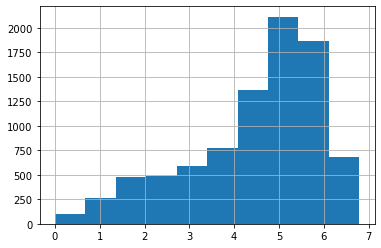

In [226]:
df_train['demand'].hist()

### Multicollinearity check

temp and temp feel are highly correlated so one of them can be removed

<AxesSubplot:>

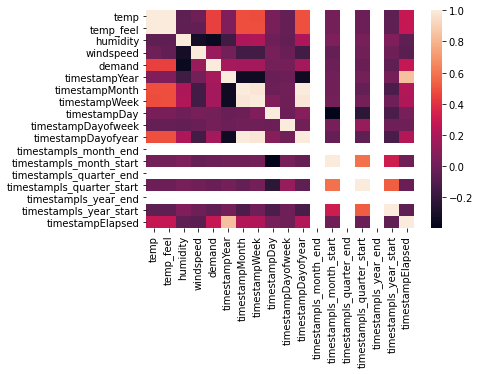

In [233]:
sns.heatmap(df_train.corr('spearman'))

## Visualization, Modeling, Machine Learning

Build a model that can predict hourly demand and identify how different features influence the decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of mean absolute error.**
- **Read the test.csv file and prepare features for testing.**

### Data Preprocessing

In [247]:
TRAIN_FEATURES = ['season', 'holiday', 'workingday', 'weather', 'temp',
        'humidity', 'windspeed', 'demand', 'timestampYear',
       'timestampMonth', 'timestampWeek', 'timestampDay', 'timestampDayofweek',
       'timestampDayofyear', 'timestampIs_month_end',
       'timestampIs_month_start', 'timestampIs_quarter_end',
       'timestampIs_quarter_start', 'timestampIs_year_end',
       'timestampIs_year_start', 'temp_feel']

In [248]:
X_train = df_train[TRAIN_FEATURES].copy()

In [249]:
X_test = df_test[[col for col in TRAIN_FEATURES if col not in ['demand']]].copy()

### The variable of type object are converted to categorical variables

In [250]:
train_cats(X_train)
apply_cats(X_test, X_train)

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


### Missing value imputation

Missing values in the numeric columns of the training set are replaced with median

The median of the training data sert used imputing the vlaue of the test data set

The categorical variable with cardinality less than 6 were converted to one hot encoded features



In [251]:
%%time
X_train, y_train, nas_train = proc_df(X_train, 'demand', max_n_cat=6 )

CPU times: user 17.8 ms, sys: 945 µs, total: 18.7 ms
Wall time: 17.5 ms


In [252]:
X_test, y_test, nas_test = proc_df(X_test, na_dict=nas_train, max_n_cat=6)

## Fit Model

LGBM regressor is used for fitting the model

In [253]:
lgb_reg = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [254]:
lgb_reg.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [255]:
y_pred_train = lgb_reg.predict(X_train)
y_pred_test = lgb_reg.predict(X_test)

In [256]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from IPython.display import HTML, display


def eval_metrics(actual, pred):
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    y_true, y_pred = np.array(actual), np.array(pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return {'rmse': rmse, 'mae': mae, 'mape': mape}

## Baseline

For baseline mean value compared to the training mean

In [257]:
ls_y_train_mean = [y_train.mean()] * len(y_train)

In [258]:
eval_metrics(y_train, ls_y_train_mean)

divide by zero encountered in true_divide


{'rmse': 1.4938775939497793, 'mae': 1.1951755750802744, 'mape': inf}

### Training MAE

The training MAE is better than the baseline

In [259]:
eval_metrics(y_train, y_pred_train)

divide by zero encountered in true_divide


{'rmse': 1.1659323291759909, 'mae': 0.8742104331308173, 'mape': inf}



**Identify the most important features of the model for management.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


## Feature Importance

The summary plot combines feature importance with feature effects

Each poing on the summary plot is a shapley value for feature and an instance

The position on the y-axis is determined by the feature and on the x-axis by the shapley value.

The color represent the value of the feature from low to high

The overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the shapley values
per feature. The features are ordered according to their importance

In [176]:
shap_values = shap.TreeExplainer(lgb_reg).shap_values(X_train)

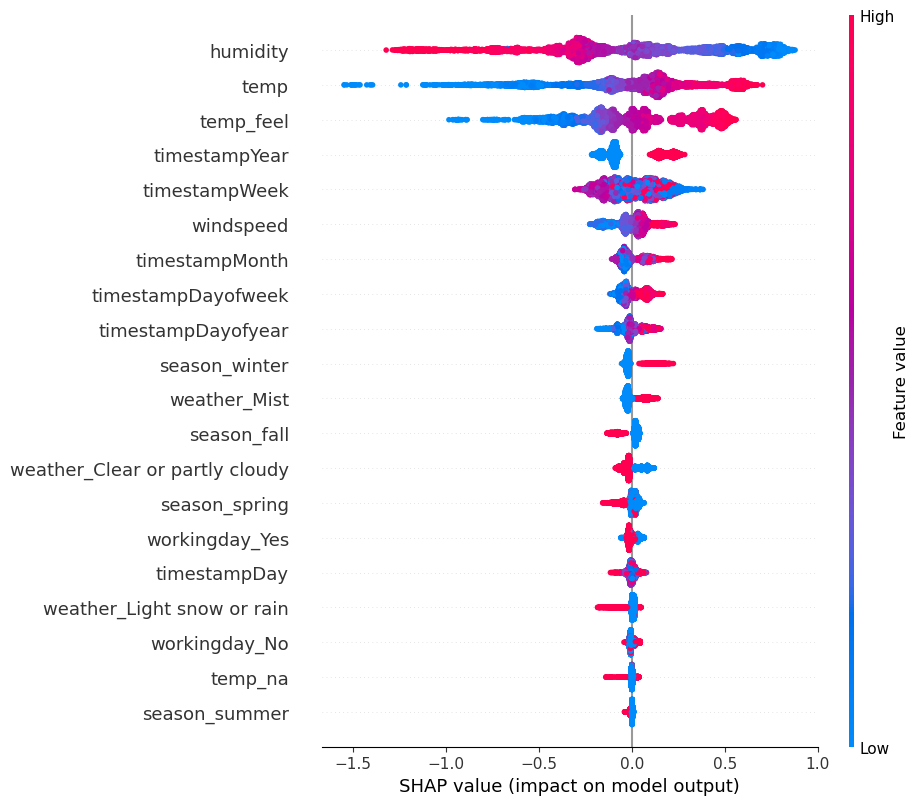

In [182]:
shap.summary_plot(shap_values, X_train)

## Partial Dependence Plot

Shap partial dependence plot shows the interaction effect between the predictor variable and the shapley value

### The increase in humidty has a negative impact on the demand for bike

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


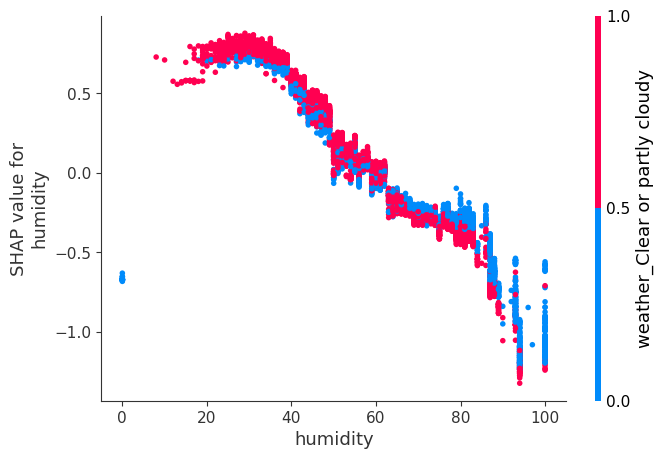

In [183]:
shap.dependence_plot('humidity', shap_values, X_train.values, feature_names=X_train.columns)

### The increase in temperature has a positive influence on the demand for bikes

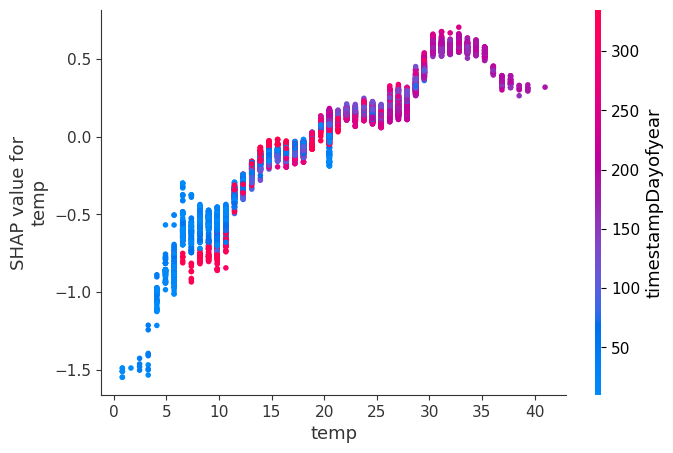

In [184]:
shap.dependence_plot('temp', shap_values, X_train.values, feature_names=X_train.columns)

### The 5th month of the year has a positive impact on the demand for bike and later half of the year sees a positive impact on demand for bikes

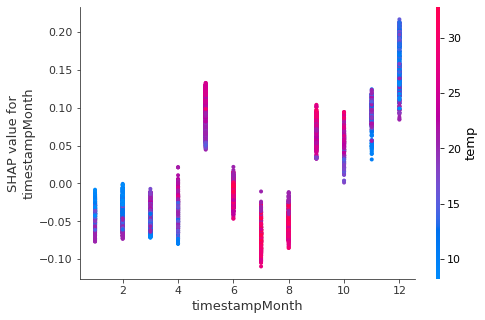

In [219]:
shap.dependence_plot('timestampMonth', shap_values, X_train.values, feature_names=X_train.columns)

> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `demand` variable. Submit a CSV file with a header row and one row per test entry.
    
The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **demand**

In [204]:
submission_df = X_test.reset_index().copy()

In [205]:
submission_df['demand'] = pd.DataFrame(y_pred_test)

In [209]:
submission_df[['id', 'demand']].head()

,id,demand
0,8709,5.052243
1,8710,4.940460
2,8712,5.330509
3,8713,5.700387
4,8714,5.704524


In [207]:
#Submission
submission_df[['id', 'demand']].to_csv('submissions.csv',index=False)

---